### Goal
To build a model for predicting a price for apartments and condominiums in Singapore.

##### Task for the current workbook:
- Visualise the data, get an impression how it looks like
- Understand how each variable can contribute to the price prediction

In [127]:
import pandas as pd
import numpy as np
import dateutil
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
sns.set()

DAYS_IN_YEAR = 365.2425
data_path="data/"
source_file = "1_data_preprocessed.csv"

In [5]:
df = pd.read_csv(data_path+source_file, parse_dates=['sale_date', 'tenure_start'] )

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99877 entries, 0 to 99876
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_name        99877 non-null  object        
 1   street              99877 non-null  object        
 2   postal_district     99877 non-null  int64         
 3   sale_type           99877 non-null  object        
 4   area_type           99877 non-null  object        
 5   property_type       99877 non-null  object        
 6   tenure_type         99877 non-null  object        
 7   mkt_segment         99877 non-null  object        
 8   sale_month          99877 non-null  int64         
 9   sale_year           99877 non-null  int64         
 10  sale_date           99877 non-null  datetime64[ns]
 11  tenure_start        71324 non-null  datetime64[ns]
 12  tenure_start_y_ago  71324 non-null  float64       
 13  tenure_years        71324 non-null  float64   

#### Insights

- pairwise relation between price_sqft and numerical variables;
    - is there any clear relationship?
        - floor level
        - max floor
        - area_sqft
        - tenure_remained
- relations of price_sqft and categorical variables

- distribution of each variable
    - does it match normal distribution?
    - outliers?
- dynamics: 
    - YoY changes in price
        - does year matter? is there any trend? 
    - MoM changes in price
        - is there any seasonality
- project_name - box plots
    - does project matter?
- geographical distribution of the price
    - how the prices change with area?


In [8]:
#In order to calculate weighted average prices, we may need total price for each transaction
price_total = df.apply(lambda x: round(x['price_sqft'] * x['area_sqft'], 0), axis = 1)
df.insert(column='price_total', value = price_total, loc=19)

### Sales time-series

#### Trend

In [9]:
years = df.sale_year.unique()
years

array([2023, 2022, 2021, 2020, 2019, 2018])

In [10]:
df.sale_date.min()

Timestamp('2018-07-01 00:00:00')

In [11]:
df.sale_date.max()

Timestamp('2023-07-01 00:00:00')

In [12]:
sales_years_annualized = df.groupby('sale_year').sum()[['area_sqft']].reset_index()
sales_years_annualized.at[0, 'area_sqft'] = sales_years_annualized.iloc[0]['area_sqft'] * 2
sales_years_annualized.at[5, 'area_sqft'] = sales_years_annualized.iloc[5]['area_sqft'] * 2

In [13]:
sales_years_annualized

,sale_year,area_sqft
0,2018,1.330067e+07
1,2019,1.679586e+07
2,2020,1.851375e+07
3,2021,3.096470e+07
4,2022,2.101105e+07
5,2023,1.877273e+07


In [14]:
df_1 = df.groupby('sale_year').agg({'price_total': 'sum', 'area_sqft': 'sum'}).reset_index()

In [15]:
df_1['price_sqft_wa'] = df_1['price_total'] / df_1['area_sqft']

In [16]:
df_1

,sale_year,price_total,area_sqft,price_sqft_wa
0,2018,1.002604e+10,6.650337e+06,1507.598751
1,2019,2.687272e+10,1.679586e+07,1599.960430
2,2020,2.842470e+10,1.851375e+07,1535.329243
3,2021,5.121227e+10,3.096470e+07,1653.892073
4,2022,3.787196e+10,2.101105e+07,1802.478551
5,2023,1.854981e+10,9.386366e+06,1976.250420


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



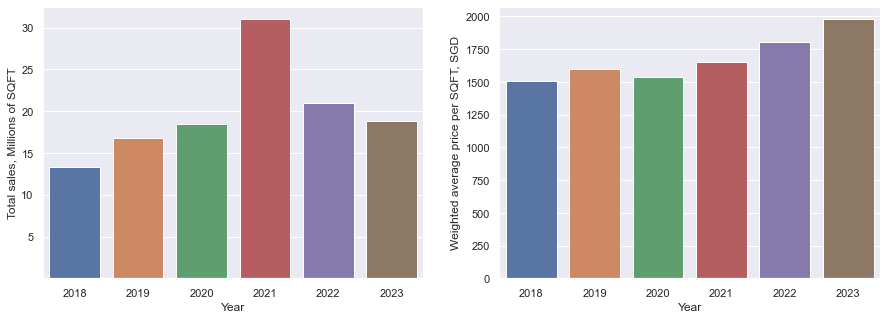

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(ax=axes[0],  data=sales_years_annualized, x='sale_year', y='area_sqft', estimator=np.sum)

y_labels = [5, 10, 15, 20, 25, 30]
y_ticks = [ i*1000000 for i in   y_labels]
y_tick_labels = [str(i) for i in y_labels ]  
axes[0].set_yticks(y_ticks, y_tick_labels) 
axes[0].set_ylabel("Total sales, Millions of SQFT")
axes[0].set_xlabel("Year")

sns.barplot(ax=axes[1], data=df_1, x='sale_year', y='price_sqft_wa', estimator=np.sum)
axes[1].set_ylabel("Weighted average price per SQFT, SGD")
axes[1].set_xlabel("Year")
fig.show()

Important: the left chart shows annualised data. The original values for 2018 starts from July, and 2023 ends at the end of July. Taking that into account, there is moderate growth in 2018-2019, and moderate decrease in 2022-2023

#### Seasonality

##### Monthly changes, year over year
- Explore month over month changes for each month of the presented years
- If these changes are consistent year to year, it may show presence of seasonality

In [101]:
sales_y_m = df.groupby(['sale_year', 'sale_month']).sum()[['area_sqft']].reset_index()
sales_y_m.sort_values(by=['sale_year', 'sale_month'], inplace=True)
sales_y_m['mom_change'] = sales_y_m['area_sqft'].pct_change()
sales_y_m.head(5)

,sale_year,sale_month,area_sqft,mom_change
0,2018,7,839880.32,NaN
1,2018,8,1091399.85,0.299471
2,2018,9,1286578.05,0.178833
3,2018,10,1119972.74,-0.129495
4,2018,11,1302799.31,0.163242


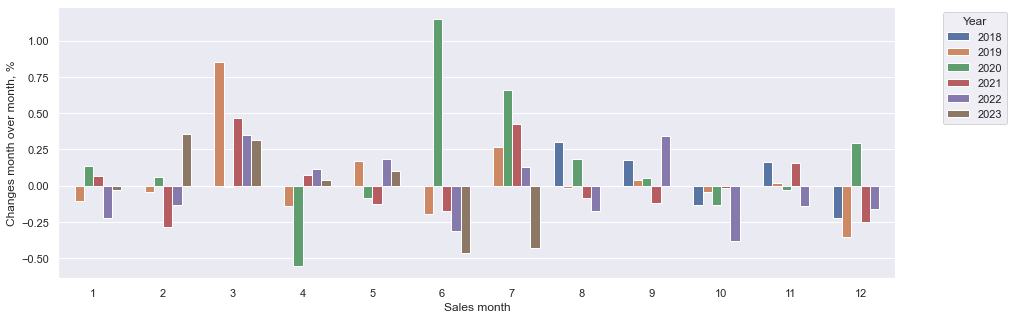

In [104]:
plt.figure(figsize = (15, 5))
sns.barplot(data=sales_y_m,y='mom_change', x='sale_month', hue='sale_year', estimator=np.sum)
plt.ylabel("Changes month over month, %")
plt.xlabel("Sales month")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Note: 
- for most months, we do not see any consistency in price chage for different years. Some months which demonstrate consistency in terms of direction of change (March, June, July, October, December). However, the magnitude of change differs significantly year over year.

### Review of individual variables

#### Price per square foot 

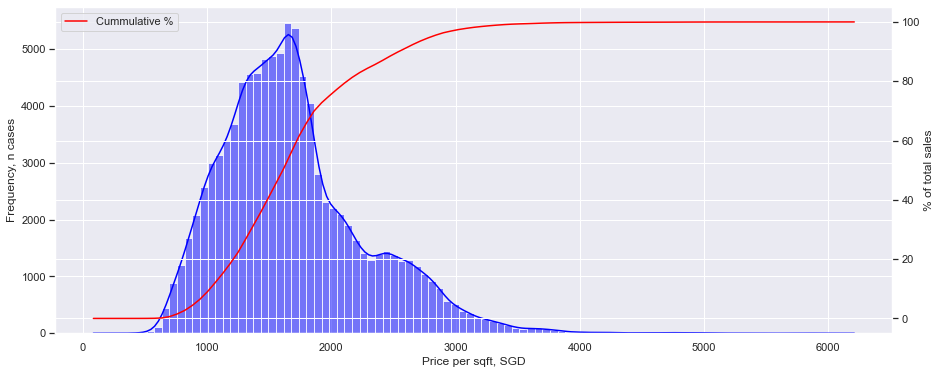

In [38]:
the_data = df.price_sqft
n_bins = 100

hist, edges = np.histogram(the_data, bins=n_bins)
cumulative_values = (np.cumsum(hist)/ hist.sum())*100

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_xlabel('Price per sqft, SGD')
ax1.set_ylabel('Frequency, n cases')
sns.histplot(the_data, bins=n_bins, kde=True, ax=ax1, color='blue', 
             label='Frequency of sales at specific price per sqft')
ax2 = ax1.twinx()
ax2.set_ylabel('% of total sales')
sns.lineplot(ax=ax2, x=edges, y=np.append(0, cumulative_values), color='red', label='Cummulative %')

plt.show()

In [39]:
df.price_sqft.describe()

count    99877.000000
mean      1692.880002
std        584.798805
min         84.000000
25%       1286.000000
50%       1609.000000
75%       1982.000000
max       6210.000000
Name: price_sqft, dtype: float64

- The frequency of price per sqf looks distributed closely to normal in its left part. 
- However, the right part (more expensive properties) have significant right tail. 

Text(0.5, 1.0, 'Distribution of the price per square foot')

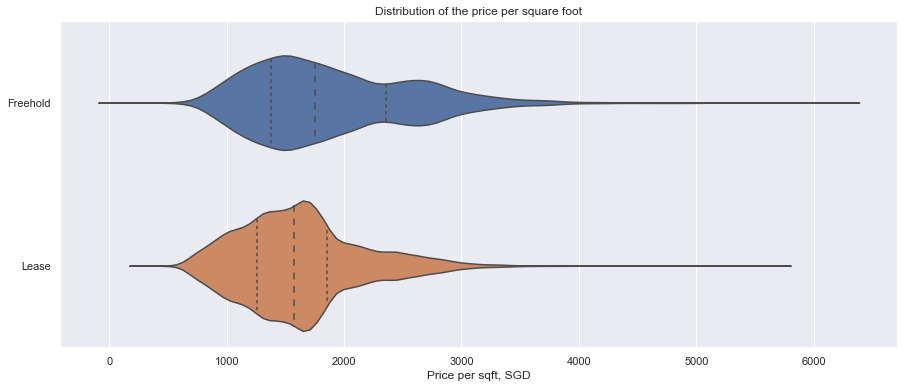

In [125]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x="price_sqft", y="tenure_type", inner="quartiles") #

# Add labels and title
plt.xlabel("Price per sqft, SGD")
plt.ylabel("")
plt.title("Distribution of the price per square foot")

- Distributions of price for freehold and lease properties looks differently. In particular, freehold category has higher share of expensive properties

#### Projects,  streets categorical variables

In [27]:
print(df.project_name.nunique())
print(df.street.nunique())
#Both variables are categorical and have large number of dimensions. Candidate for PCA

2222
835


Note:
- After encoding these two variables will create over 3000 new dimensions. 
- Running any algorithm on such a dataset will be computationally expensive. 
- We can consider a simpler model without including projects and streets, and a model with dimensionality reduction

##### Distribution of transactions by project

In [77]:
df_projects_frequency = df.groupby(['project_name']).count()[['price_sqft']].sort_values(by='price_sqft', 
                                        ascending=False)
df_projects_frequency.columns = ['n_deals']
df_projects_frequency['cum_sum'] = df_projects_frequency['n_deals'].cumsum()
total_deals = df_projects_frequency['n_deals'].sum()
df_projects_frequency['cum_sum_pct'] = (df_projects_frequency['cum_sum'] / total_deals)*100

In [78]:
df_projects_frequency[['n_deals']].head(10)

,n_deals
project_name,
TREASURE AT TAMPINES,2278
NORMANTON PARK,1841
PARC ESTA,1531
THE FLORENCE RESIDENCES,1457
PARC CLEMATIS,1456
JADESCAPE,1275
STIRLING RESIDENCES,1136
RIVERFRONT RESIDENCES,1126
AVENUE SOUTH RESIDENCE,1078


In [79]:
df_projects_frequency[['n_deals']].tail(5)

,n_deals
project_name,
CASA ESPANIA,1
MARTIA 8,1
MARTIN EDGE,1
TWO8ONE STUDIO,1
SANCTUARY@NEWTON,1


In [69]:
df_projects_frequency.n_deals.describe()

count    2222.000000
mean       44.949145
std       125.910582
min         1.000000
25%         4.000000
50%        12.000000
75%        34.000000
max      2278.000000
Name: n_deals, dtype: float64

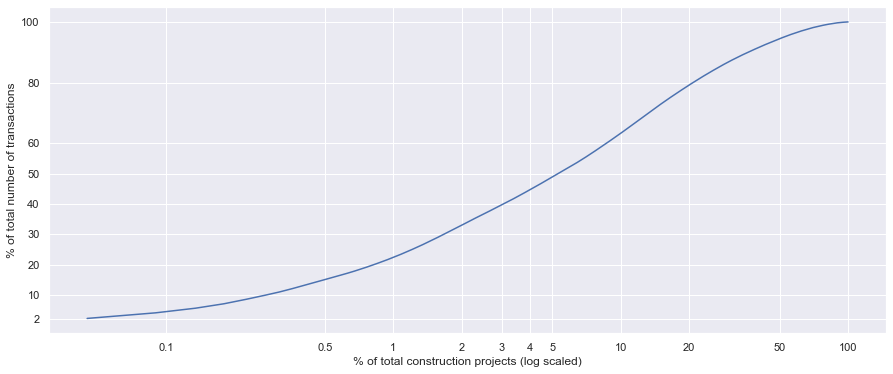

In [65]:
n_projects = df_projects_frequency.shape[0] + 1
#[i for i in range(1, n_projects)]
pct_projects = [(i/n_projects)*100 for i in range(1, n_projects)]

plt.figure(figsize=(15, 6))
sns.lineplot(data=df_projects_frequency, y='cum_sum_pct', x=pct_projects)
plt.xscale("log")

x_ticks = [.1, .5, 1, 2, 3, 4, 5, 10, 20, 50, 100]  
x_tick_labels = [str(x) for x in x_ticks ]  
plt.xticks(x_ticks, x_tick_labels) 

y_ticks = [2, 10, 20, 30, 40, 50, 60, 80, 100]  
y_tick_labels = ['2', '10', '20', '30', '40', '50', '60', '80', '100' ]  
plt.yticks(y_ticks, y_tick_labels) 

plt.xlabel("% of total construction projects (log scaled)")
plt.ylabel("% of total number of transactions")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



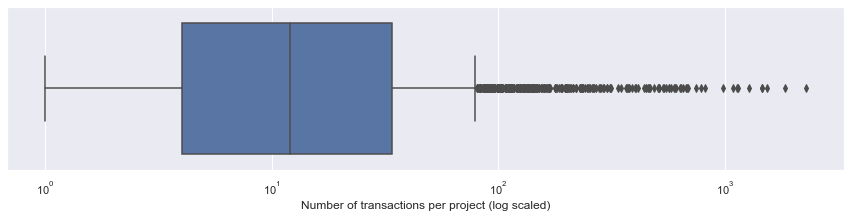

In [84]:
plt.figure(figsize=(15, 3))
sns.boxplot(df_projects_frequency['n_deals'])
plt.xscale("log")
plt.xlabel("Number of transactions per project (log scaled)")
plt.show()

Note: 
- there is a small number of projects with high volume of transactions and large number of projects with small volume of transactions.
- e.g. 50% of transactions belongs to 5% of the projects

#### Other categorical variables

##### Tenure type

<AxesSubplot:xlabel='sale_year', ylabel='area_sqft'>

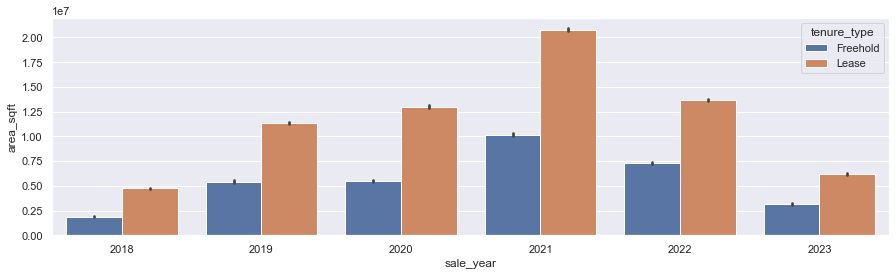

In [33]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='sale_year', y='area_sqft', hue='tenure_type', estimator=np.sum)

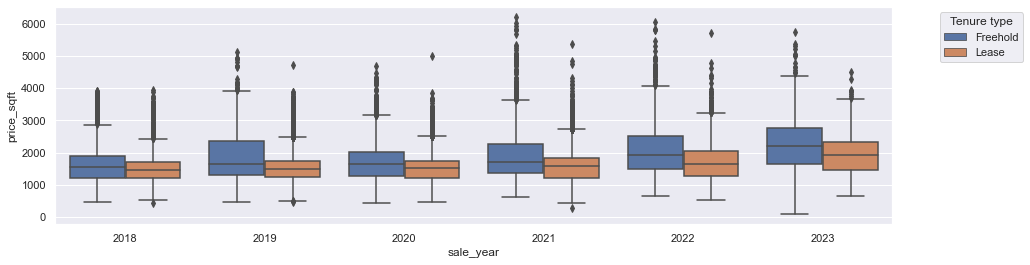

In [34]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, y='price_sqft', x='sale_year', hue='tenure_type',)
plt.legend(title='Tenure type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Sale type

<AxesSubplot:xlabel='sale_year', ylabel='area_sqft'>

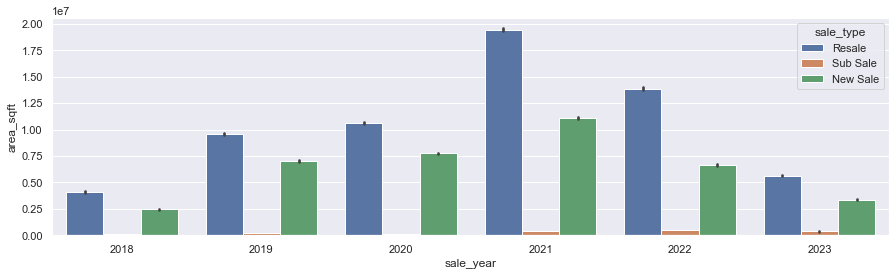

In [35]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='sale_year', y='area_sqft', hue='sale_type', estimator=np.sum)

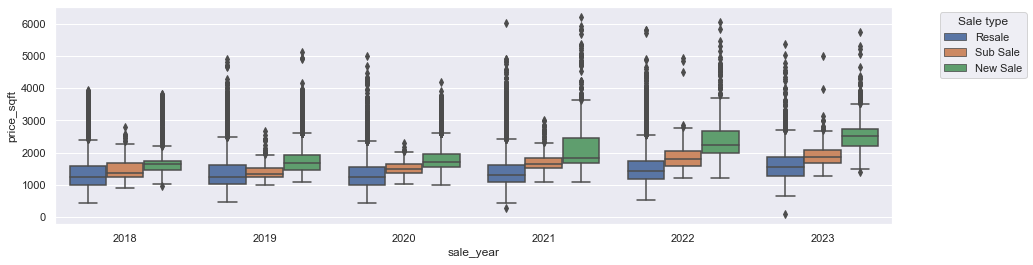

In [36]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, y='price_sqft', x='sale_year', hue='sale_type',)
plt.legend(title='Sale type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Note: type of sale looks important variable. For existing properties ("resale") the median prices and distributions changed not much, while for new sales and for sub sale (sale in unfinished project) increased more significantly

##### Property type

<AxesSubplot:xlabel='sale_year', ylabel='area_sqft'>

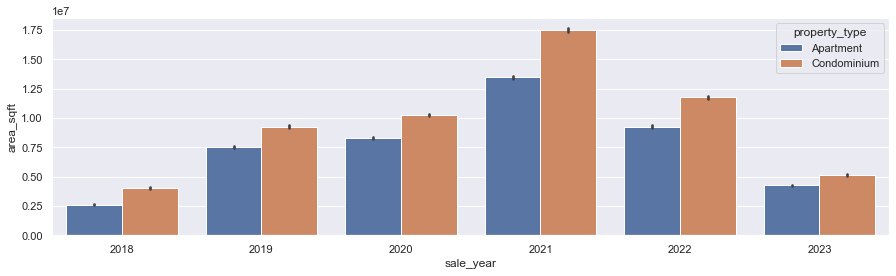

In [37]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='sale_year', y='area_sqft', hue='property_type', estimator=np.sum)

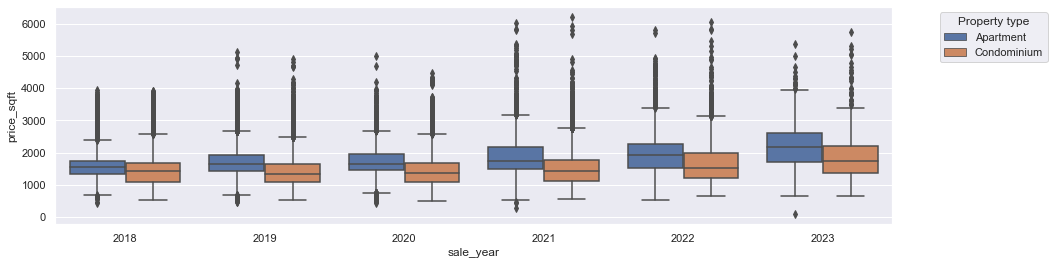

In [38]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, y='price_sqft', x='sale_year', hue='property_type',)
plt.legend(title='Property type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [39]:
df_pty_type = df.groupby("property_type").agg({'price_total': 'sum', 'area_sqft': 'sum'}).reset_index()
df_pty_type['price_wav'] = df_pty_type['price_total'] / df_pty_type['area_sqft']
df_pty_type

,property_type,price_total,area_sqft,price_wav
0,Apartment,8.317627e+10,4.543341e+07,1830.729292
1,Condominium,8.978122e+10,5.788865e+07,1550.929628


Note:
- property type is clearly important variable
- this is strange that overall condomimium prices look higher than apartment prices.

##### Market segment

<AxesSubplot:xlabel='sale_year', ylabel='area_sqft'>

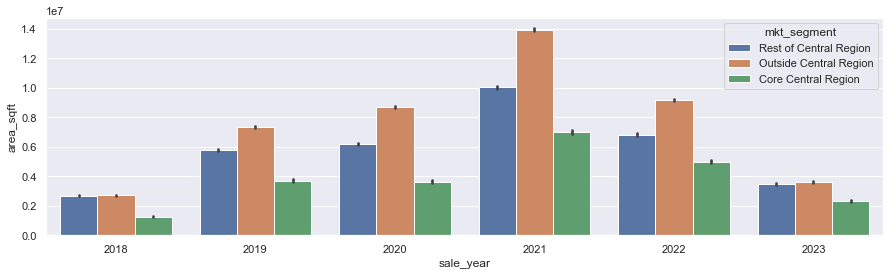

In [40]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='sale_year', y='area_sqft', hue='mkt_segment', estimator=np.sum)

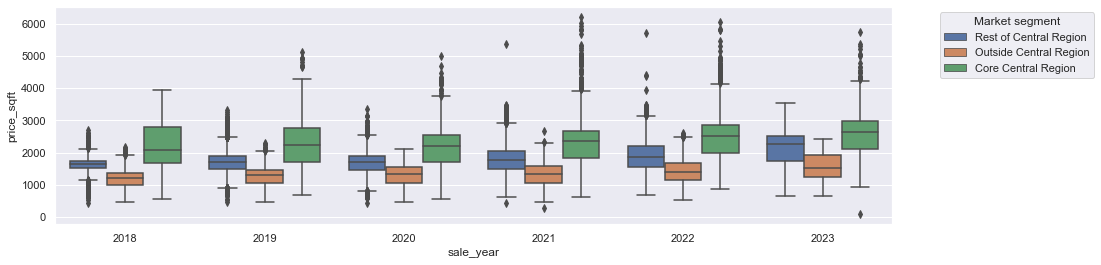

In [41]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, y='price_sqft', x='sale_year', hue='mkt_segment',)
plt.legend(title='Market segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Note:
- market segment (geographical) is important

##### Area type

<AxesSubplot:xlabel='sale_year', ylabel='area_sqft'>

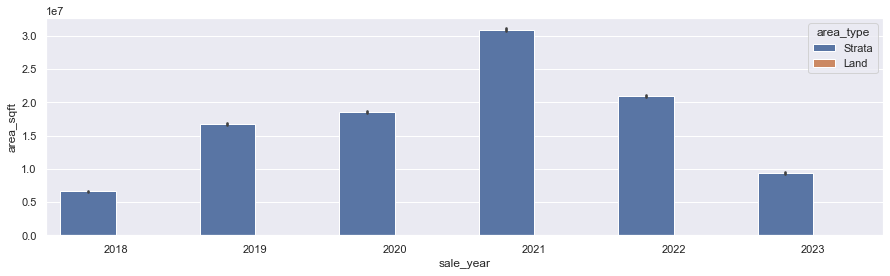

In [42]:
plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='sale_year', y='area_sqft', hue='area_type', estimator=np.sum)

Note: area type variable can be easily ignored

Note: for all categorical variables, year looks important

#### Numeric variables

In [43]:
#floor level and max floor may have some predictative power, however area and remaining tenure seem useless.

In [44]:
def plot_variables_freehold(df):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
    sns.scatterplot(data=df, ax=ax[0], x='floor_level', y='price_sqft')
    sns.scatterplot(data=df, ax=ax[1], x='max_floor', y='price_sqft', )
    sns.scatterplot(data=df, ax=ax[2], x='area_sqft', y='price_sqft', )
    plt.tight_layout()
    plt.show()

def plot_variables_lease(df):
    fig, ax = plt.subplots(2, 4, figsize=(16, 10), sharey=True)
    sns.scatterplot(data=df, ax=ax[0, 0], x='tenure_start', y='price_sqft', )
    sns.scatterplot(data=df, ax=ax[0, 1], x='tenure_remained', y='price_sqft', )
    sns.scatterplot(data=df[df['tenure_remained'] < 100], ax=ax[0, 2], x='tenure_remained', y='price_sqft', 
                )
    sns.scatterplot(data=df, ax=ax[0, 3], x='tenure_start_y_ago', y='price_sqft')
    #tenure_start_y_ago
    sns.scatterplot(data=df, ax=ax[1, 0], x='floor_level', y='price_sqft',)
    sns.scatterplot(data=df, ax=ax[1, 1], x='max_floor', y='price_sqft', )
    sns.scatterplot(data=df, ax=ax[1, 2], x='area_sqft', y='price_sqft', )
    sns.scatterplot(data=df[df['area_sqft'] < 5000], ax=ax[1, 3], x='area_sqft', y='price_sqft', )
    plt.tight_layout()
    plt.show()

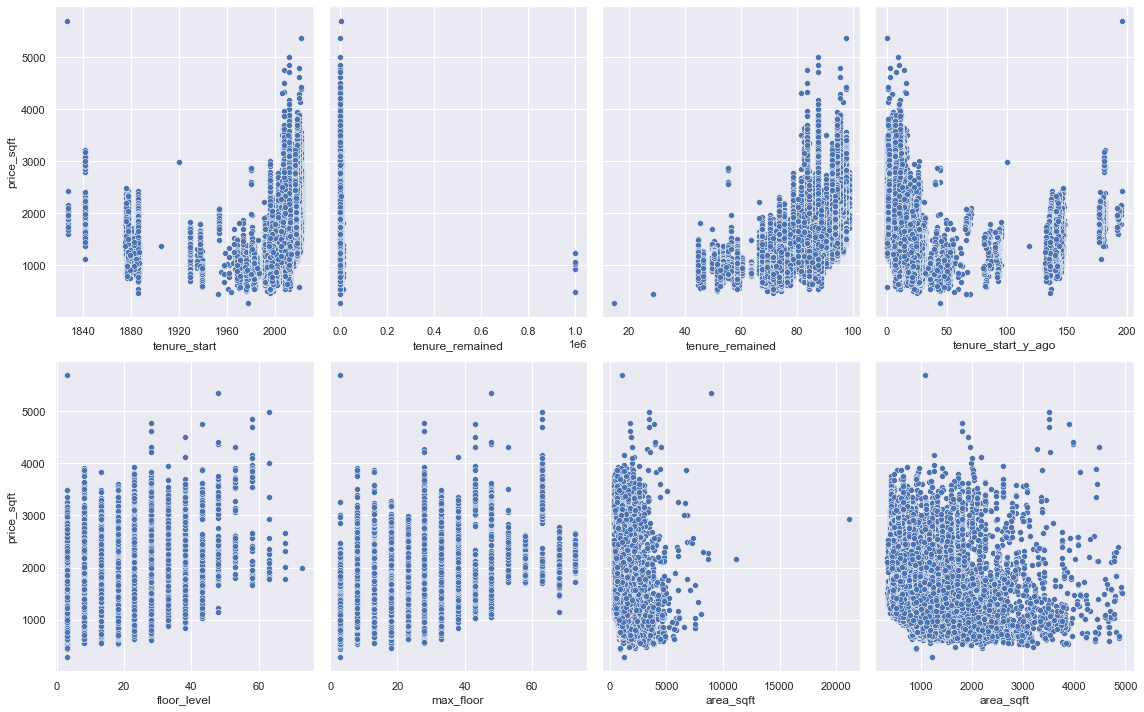

In [45]:
plot_variables_lease(df[df.tenure_type=='Lease'])

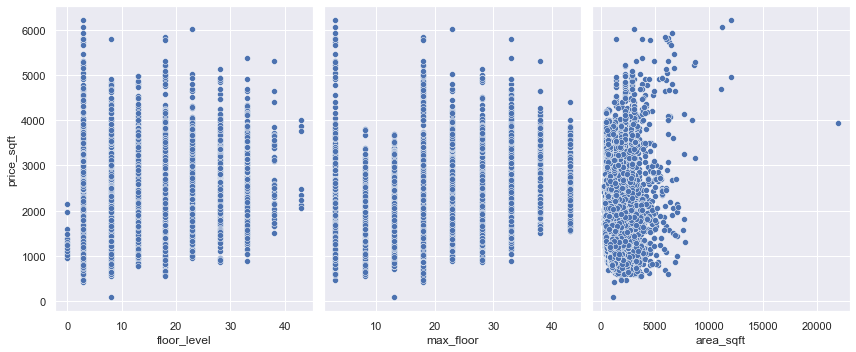

In [46]:
plot_variables_freehold(df[df.tenure_type=='Freehold'])

In [137]:
df[['price_sqft', 'area_sqft', 'floor_level', 'max_floor', 'tenure_remained', 'tenure_start_y_ago']].corr()

,price_sqft,area_sqft,floor_level,max_floor,tenure_remained,tenure_start_y_ago
price_sqft,1.000000,-0.059845,0.317420,0.365298,-0.011295,-0.204972
area_sqft,-0.059845,1.000000,0.021120,-0.035741,0.008284,0.218605
floor_level,0.317420,0.021120,1.000000,0.680418,-0.009758,-0.123442
max_floor,0.365298,-0.035741,0.680418,1.000000,-0.004670,-0.180601
tenure_remained,-0.011295,0.008284,-0.009758,-0.004670,1.000000,0.027169
tenure_start_y_ago,-0.204972,0.218605,-0.123442,-0.180601,0.027169,1.000000


#### Removing outliers

##### Leased properties

In [135]:
df_lease_no_outliers = df[df.tenure_type == 'Lease']
df_lease_no_outliers = df_lease_no_outliers[df_lease_no_outliers.tenure_remained < 100] 
df_lease_no_outliers = df_lease_no_outliers[df_lease_no_outliers.tenure_start_y_ago < 50]
df_lease_no_outliers = df_lease_no_outliers[df_lease_no_outliers.area_sqft < 5000]
df_lease_no_outliers = df_lease_no_outliers[df_lease_no_outliers.price_sqft < 4000]


In [138]:
df_lease_no_outliers[['price_sqft', 'area_sqft', 'floor_level', 'max_floor', 
                'tenure_remained', 'tenure_start_y_ago']].corr()

,price_sqft,area_sqft,floor_level,max_floor,tenure_remained,tenure_start_y_ago
price_sqft,1.000000,-0.256381,0.378518,0.453547,0.571471,-0.535974
area_sqft,-0.256381,1.000000,0.004910,-0.046112,-0.414742,0.434818
floor_level,0.378518,0.004910,1.000000,0.647144,0.095866,-0.082810
max_floor,0.453547,-0.046112,0.647144,1.000000,0.125392,-0.113741
tenure_remained,0.571471,-0.414742,0.095866,0.125392,1.000000,-0.969615
tenure_start_y_ago,-0.535974,0.434818,-0.082810,-0.113741,-0.969615,1.000000


##### Freehold properties

In [146]:
df_freehold_no_outliers = df[df.tenure_type == 'Freehold']
df_freehold_no_outliers.drop(columns=['tenure_start', 'tenure_start_y_ago', 'tenure_years', 
                                      'tenure_remained' ], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
df_freehold_no_outliers = df_freehold_no_outliers[df_freehold_no_outliers.area_sqft < 5000]
df_freehold_no_outliers = df_freehold_no_outliers[df_freehold_no_outliers.price_sqft < 4000]

In [140]:
df[df.tenure_type == 'Freehold'][['price_sqft', 'area_sqft', 'floor_level', 'max_floor']].corr()

,price_sqft,area_sqft,floor_level,max_floor
price_sqft,1.000000,0.064293,0.387601,0.483782
area_sqft,0.064293,1.000000,0.139547,0.114011
floor_level,0.387601,0.139547,1.000000,0.730737
max_floor,0.483782,0.114011,0.730737,1.000000


In [139]:
df_freehold_no_outliers[['price_sqft', 'area_sqft', 'floor_level', 'max_floor']].corr()

,price_sqft,area_sqft,floor_level,max_floor
price_sqft,1.000000,-0.036240,0.386680,0.493709
area_sqft,-0.036240,1.000000,0.125270,0.115656
floor_level,0.386680,0.125270,1.000000,0.729577
max_floor,0.493709,0.115656,0.729577,1.000000


Note: 
- correlation coefficients for numeric variables and price_sqft did not looked significant
- however, after we splitted properties by tenure type to freehold and leases, the correlation coefficients for leases look more significant 
- for freeholds the correlation of floor_level and max_floor remained the same, but area_sqft has changed the sign from positive to negative

#### Location variables

In order to visualize the price differences by territory, we will split the dataset into a few strata based on price_sqft:
- left tail outliers (very cheap properties)
- left from the median
- right to the median, bell-shped
- expensive, right tail
- very expensive, right tail outliers

In [50]:
def stratify_price(s):
    price = s['price_sqft']
    if price < 600:
        return 0
    elif price < 1700:
        return 1
    elif price < 3000:
        return 2
    elif price < 4000:
        return 3
    else:
        return 4
pallette = {0: 'purple', 1: 'lightblue', 2: 'teal', 3: 'red', 4: 'orange', }

df_stratified = df.copy()
df_stratified['stratum'] = df_stratified.apply(stratify_price, axis=1)

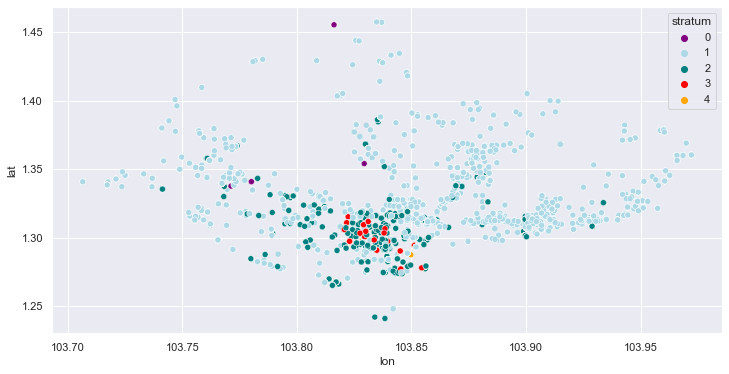

In [51]:
# based on street location
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_stratified, x='lon', y='lat', hue='stratum', palette=pallette)
plt.show()

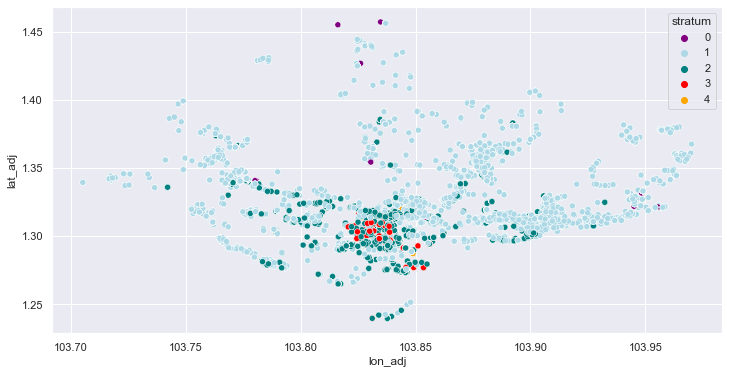

In [52]:
# based on property location
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_stratified, x='lon_adj', y='lat_adj', hue='stratum', palette=pallette)
plt.show()

Note: OneMap coordinates (lower chart) for specific projects look slightly more precise than street-based coordinates (upper chart), although they are not totally different

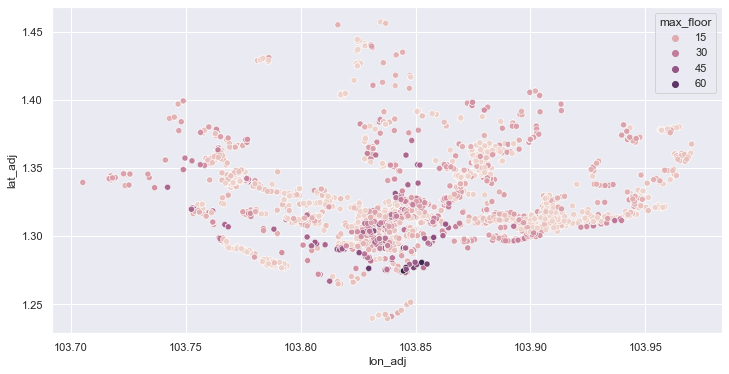

In [53]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_stratified, x='lon_adj', y='lat_adj', hue='max_floor')
plt.show()

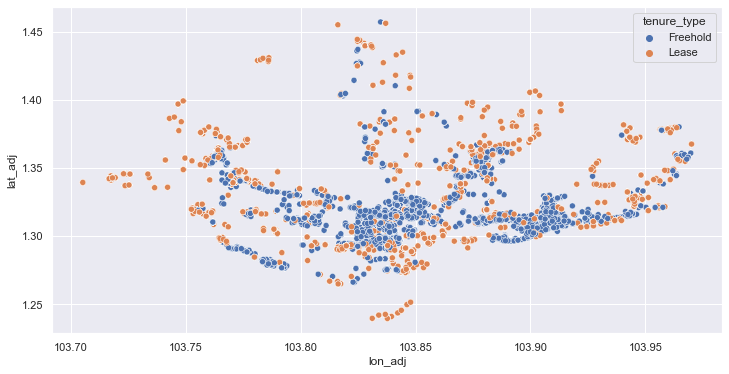

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_stratified, x='lon_adj', y='lat_adj', hue='tenure_type')
plt.show()

First look at the data does not point at any clear linear relationships within the data, although there are probably some clusters

### Summary

- Numeric variables:
    - the data is quite disperse and contains large number of significant outliers in terms of price, area and tenure duration. This data shows some correlation of price with floor level.
    - After removing outliers, the numeric variables demonstrate higher correlations, both positive and negative, with price.
    - In terms of timing, sales volumes and price data looks non-stationary and does not demonstrate clear seasonality, although there is some up trend for price since 2020 and down trend for sales volume since 2021

- Categorical variables:
    - There are clear differences in distributions for price value for different categories. The only variable which clearly does not have predictative power is area_type.

- Location variables
    - Location expresses as lat and lon has visible impact on the price

### Approach to prediction   
- None of the variables gives us clearly visible pattern which would allow us to predict the price straightaway.
- However, many variables demonstrate certain impact on the price (e.g. correlation with price)
- Due to clear non-linear patterns, we unlikely use Linear regression
- However, Decision Trees and Random Forest regressions may be effective
- Also we may attempt using neural networks for predicting the price
- We will train our models on the datasets cleared from outliers
- We will build the regression models separately for freehold and leases in order to keep tenure term variables


#### Saving data without outliers

In [149]:
df_lease_no_outliers.to_csv(data_path+"2_lease_no_outliers.csv", index=False)

In [151]:
df_freehold_no_outliers.to_csv(data_path+"2_freehold_no_outliers.csv", index=False)